# Introduction

This notebook generates aggregated traces based on the alibaba traces.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("alibaba_2apps_1s.csv.gz", index_col=0, parse_dates=True)
df.head()

,app0,app1
datetime,,
1970-01-25 00:00:03+08:00,0.0,1.0
1970-01-25 00:00:04+08:00,0.0,0.0
1970-01-25 00:00:05+08:00,0.0,0.0
1970-01-25 00:00:06+08:00,0.0,0.0
1970-01-25 00:00:07+08:00,0.0,0.0


In [3]:
# Aggregation windows in minutes
window_sizes_min = [5, 15, 60]

# Create a dictionary to store the aggregated dataframes. The keys will be a
# tuple with the window size and the aggregation function.
df_agg = {}
for window_size in window_sizes_min:
    window_size_str = f"{window_size}T"

    # Resample using the max in the window size. Multiply by 60 to pass to
    # minutes and then by the window size (in minutes) to get the total number
    # of requests in the window.
    df_agg[(window_size, "max")] = df.resample(window_size_str).max() * 60 * window_size
    df_agg[(window_size, "max")].to_csv(f"alibaba_2apps_{window_size_str}_max.csv")

    # Resample using the sum in the window size.
    df_agg[(window_size, "sum")] = df.resample(window_size_str).sum()
    df_agg[(window_size, "sum")].to_csv(f"alibaba_2apps_{window_size_str}_sum.csv")

# Compare window sizes

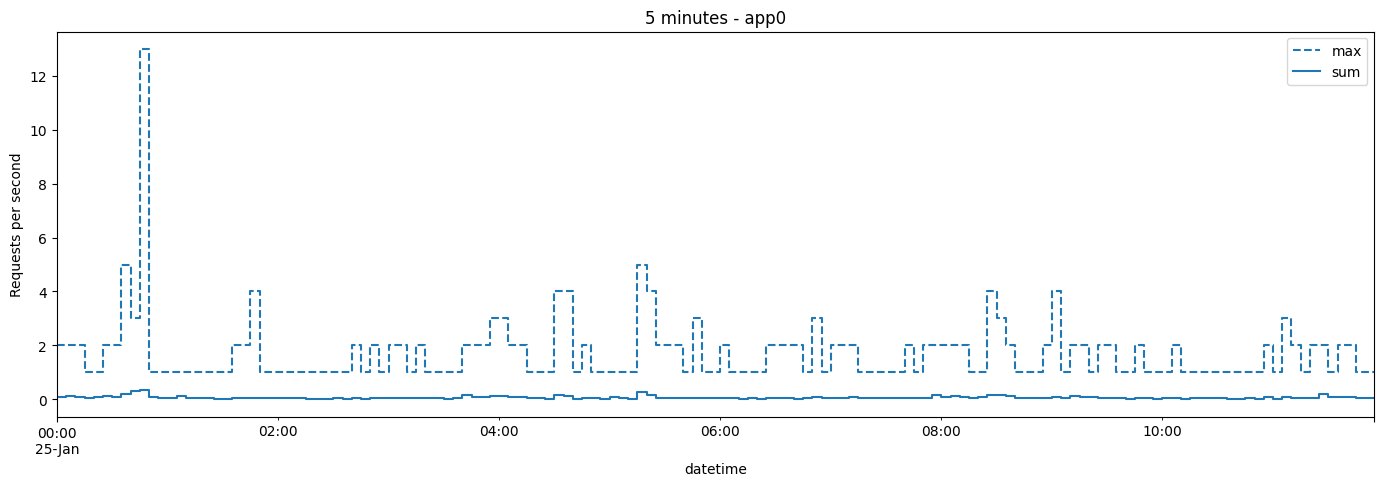

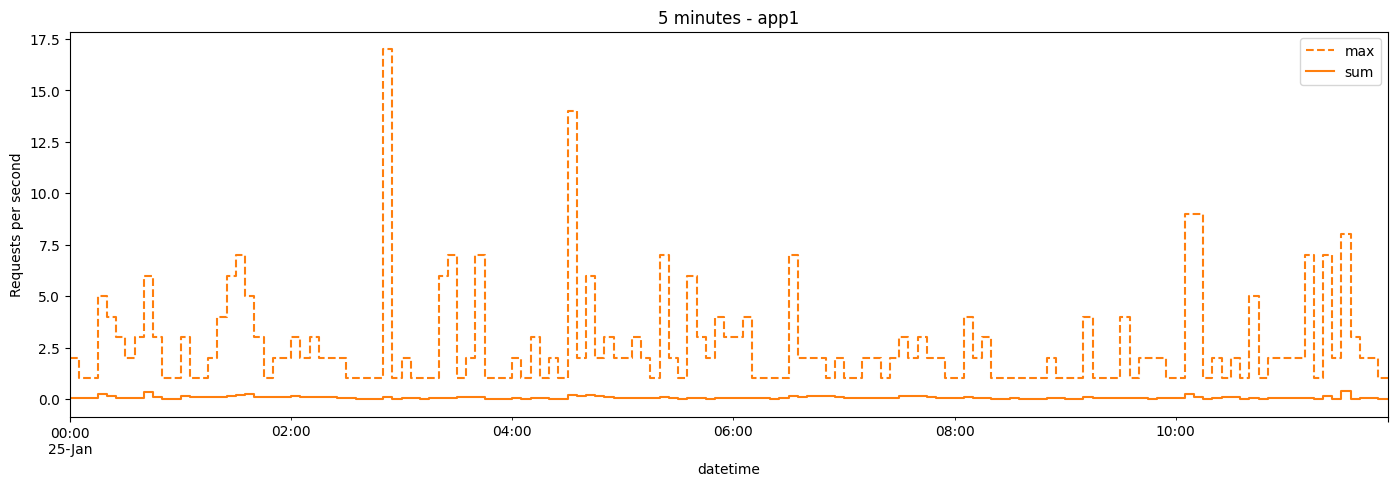

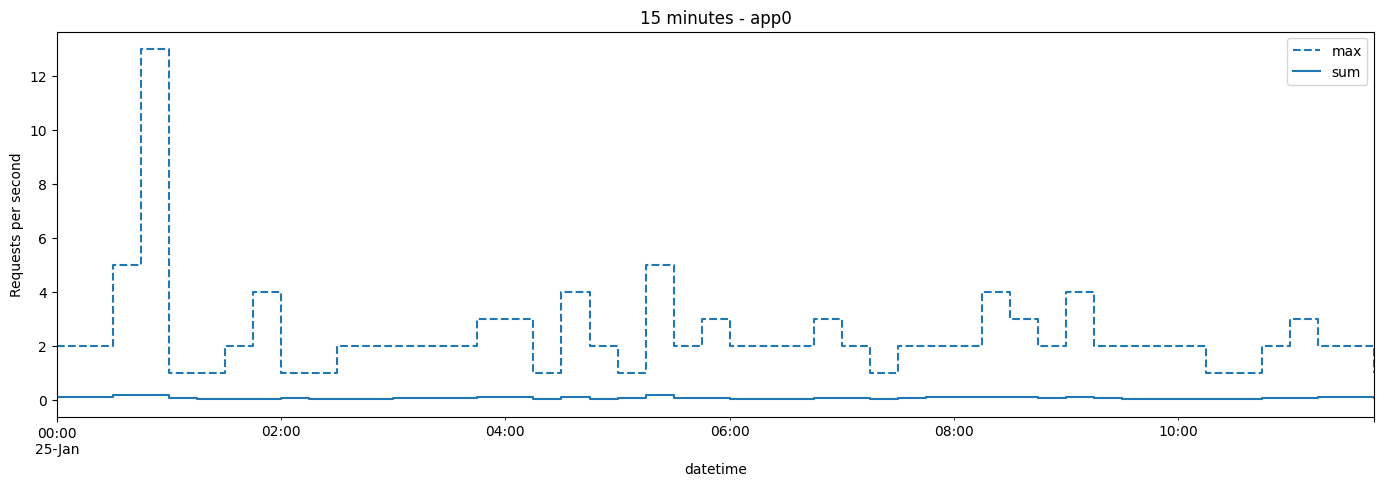

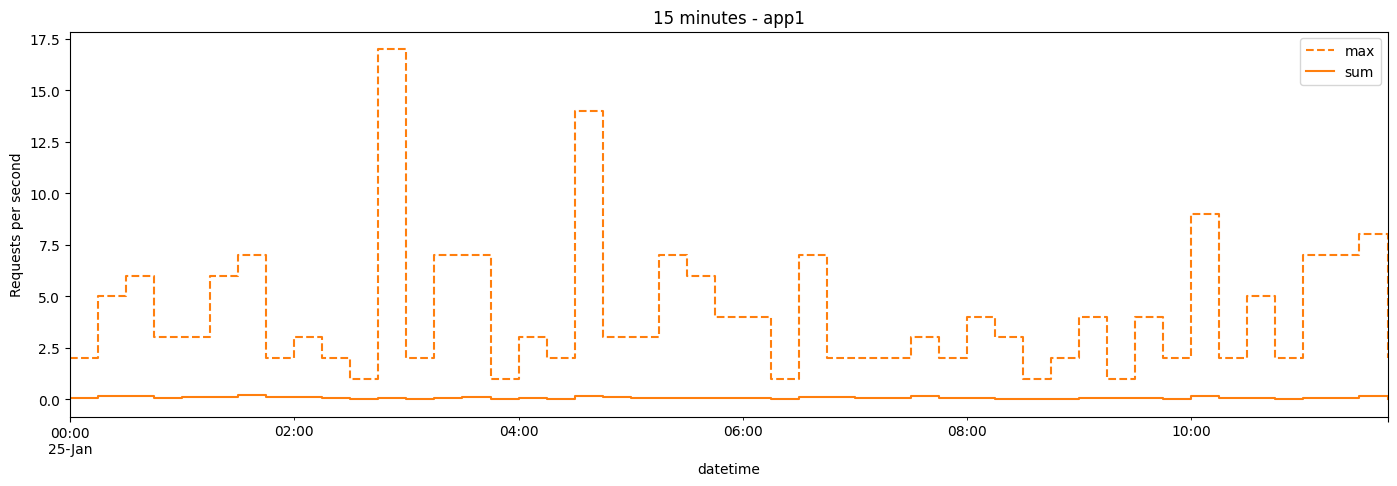

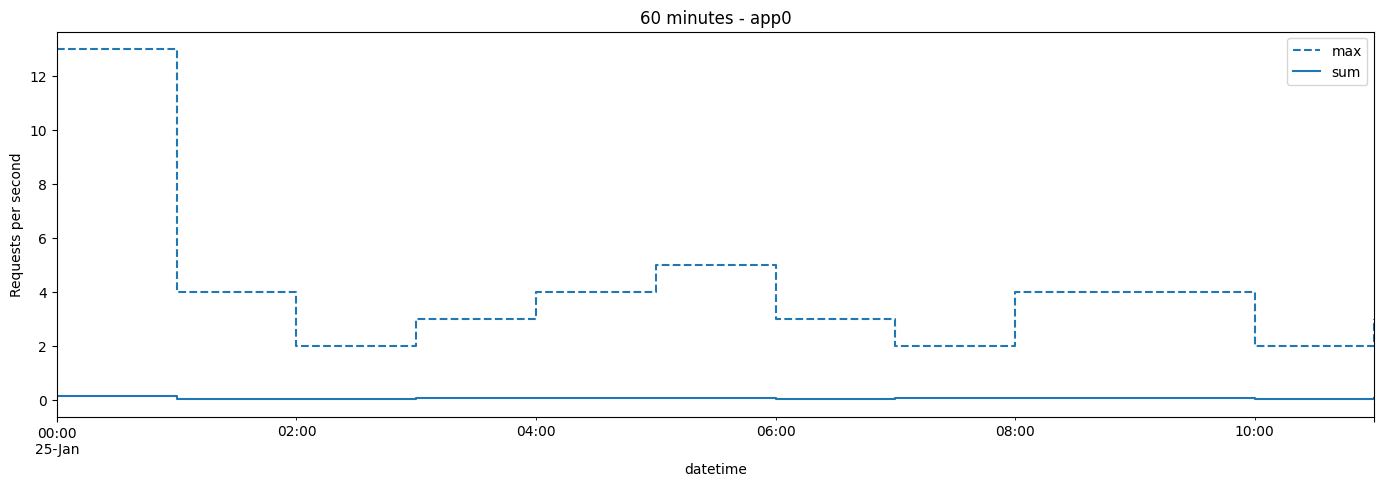

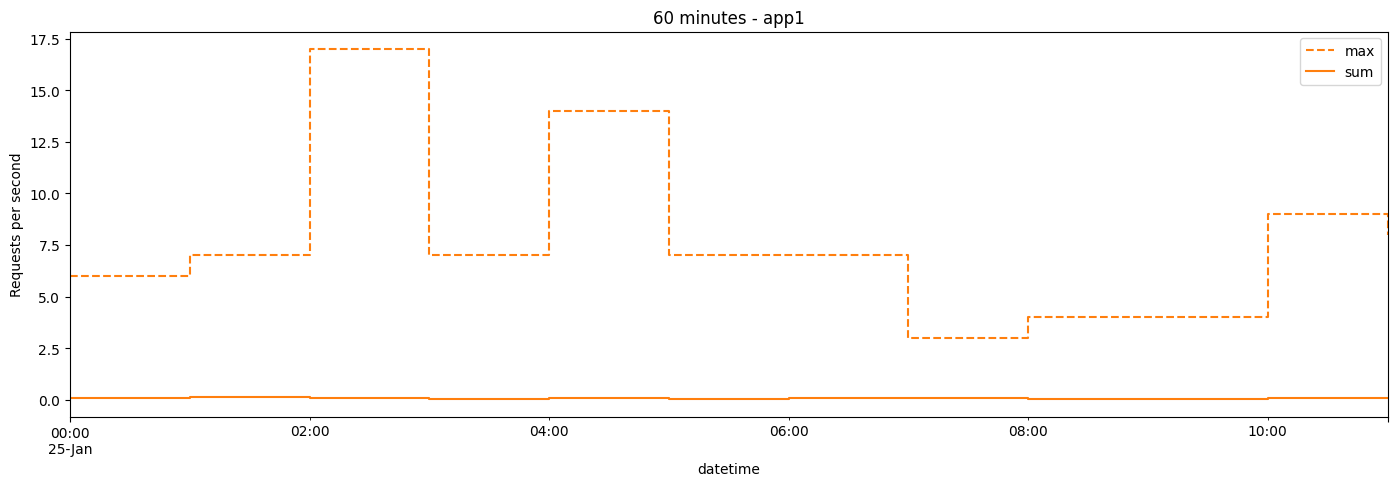

In [4]:
# Plot the first 12 hours of the aggregated dataframes
color = {
    "app0": "tab:blue",
    "app1": "tab:orange",
}
style = {
    "max": "--",
    "sum": "-",
}
for window_size in window_sizes_min:
    zoom = 12 * 60 // window_size
    for app in ["app0", "app1"]:
        fig, ax = plt.subplots(figsize=(17, 5))
        for agg_func in ["max", "sum"]:
            s_app = df_agg[(window_size, agg_func)].iloc[:zoom][app] / (
                60 * window_size
            )
            s_app.plot(
                ax=ax,
                label=f"{agg_func}",
                style=style[agg_func],
                color=color[app],
                drawstyle="steps-post",
            )

        plt.ylabel("Requests per second")
        plt.title(f"{window_size} minutes - {app}")
        plt.legend()

# Compare aggregation windows

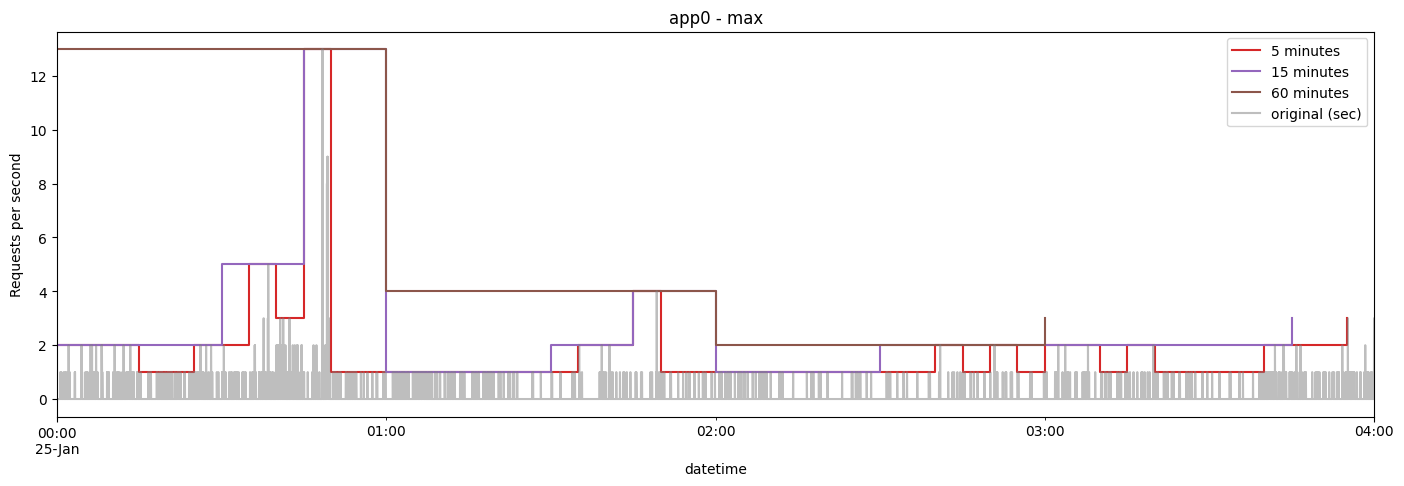

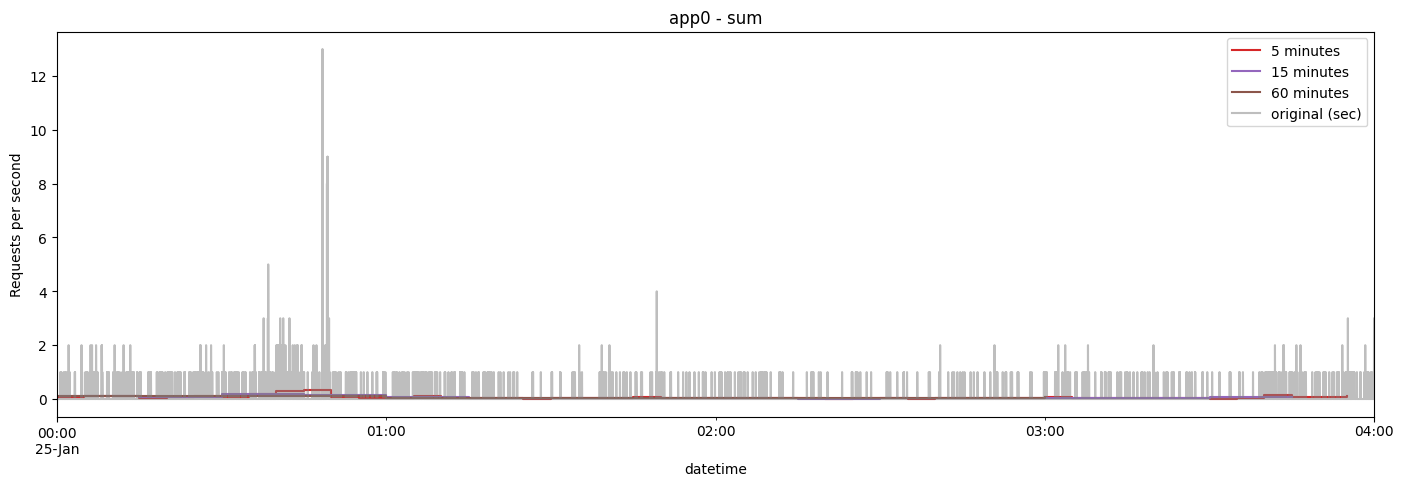

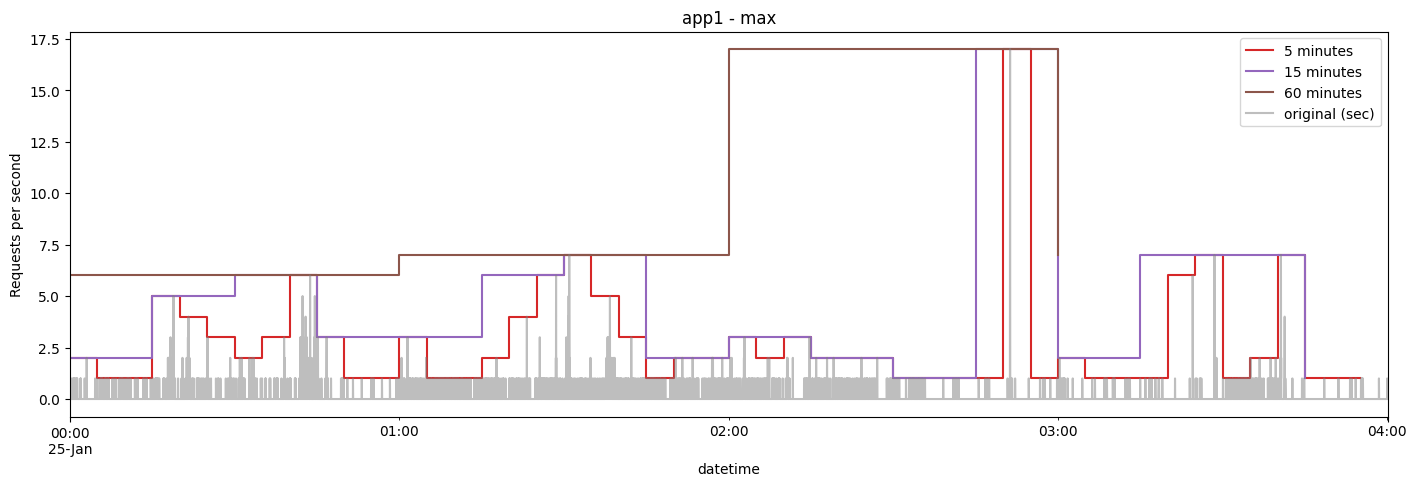

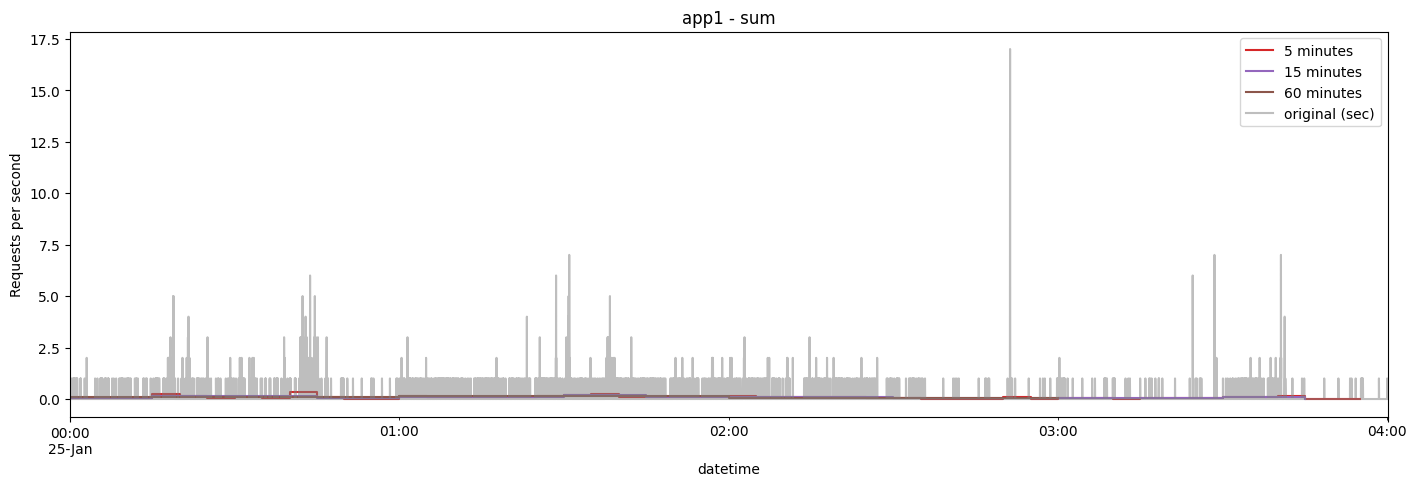

In [6]:
# Plot the first 2 hours aggregated with different window sizes
color_w = {
    5: "tab:red",
    15: "tab:purple",
    60: "tab:brown",
}
hours_zoom = 4
for app in ["app0", "app1"]:
    for agg_func in ["max", "sum"]:
        fig, ax = plt.subplots(figsize=(17, 5))
        for window_size in window_sizes_min:
            zoom = hours_zoom * 60 // window_size
            s_app = df_agg[(window_size, agg_func)].iloc[:zoom][app] / (
                60 * window_size
            )
            s_app.plot(
                ax=ax,
                label=f"{window_size} minutes",
                style=style[agg_func],
                color=color_w[window_size],
                drawstyle="steps-post",
            )

        half_day_sec = hours_zoom * 60 * 60
        df.iloc[:half_day_sec][app].plot(
            ax=ax,
            label="original (sec)",
            # style=".",
            color="tab:grey",
            # drawstyle="steps-post"
            alpha=0.5,
        )

        plt.ylabel("Requests per second")
        plt.title(f"{app} - {agg_func}")
        plt.legend()